# LSTM model

In [1]:
import pandas as pd
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
pd.set_option('display.max_colwidth', None)

## Read data

In [3]:
train_data = pd.read_csv('../dataset/train.tsv', sep='\t')
train_data = train_data.fillna('unknown')

validation_data = pd.read_csv('../dataset/test.tsv', sep='\t')
validation_data = validation_data.fillna('unknown')

In [4]:
train_data['q1_label'].value_counts()

yes    4428
no     1977
Name: q1_label, dtype: int64

In [5]:
train_data['q2_label'].value_counts()

no         3902
unknown    2024
yes         479
Name: q2_label, dtype: int64

In [6]:
train_data['q3_label'].value_counts()

yes        4315
unknown    1962
no          128
Name: q3_label, dtype: int64

In [7]:
train_data['q4_label'].value_counts()

no         3745
unknown    1972
yes         688
Name: q4_label, dtype: int64

In [8]:
# One hot encoding
train_data = pd.get_dummies(train_data, columns=['q2_label', 'q3_label', 'q4_label'], prefix=["q2_label_is", "q3_label_is", "q4_label_is"] )

# One hot encoding
validation_data = pd.get_dummies(validation_data, columns=['q2_label', 'q3_label', 'q4_label'], prefix=["q2_label_is", "q3_label_is", "q4_label_is"] )

In [9]:
train_data.head(2)

,tweet_no,tweet_text,q1_label,q5_label,q6_label,q7_label,language,tweet_link,tweet_link_count,preprocessed_tweet_text,...,preprocessed_tweet_text_no_link,q2_label_is_no,q2_label_is_unknown,q2_label_is_yes,q3_label_is_no,q3_label_is_unknown,q3_label_is_yes,q4_label_is_no,q4_label_is_unknown,q4_label_is_yes
0,1,For the average American the best way to tell if you have covid-19 is to cough in a rich person’s face and wait for their test results,no,unknown,no,no,en,[],0,For the average American the best way to tell if you have covid-19 is to cough in a rich person’s face and wait for their test results,...,For the average American the best way to tell if you have covid-19 is to cough in a rich person’s face and wait for their test results,0,1,0,0,1,0,0,1,0
1,2,this is fucking bullshit,no,unknown,no,no,en,[],0,this is fucking bullshit,...,this is fucking bullshit,0,1,0,0,1,0,0,1,0


In [10]:
train_data = train_data[['preprocessed_tweet_text', 'q1_label', 
                         'q2_label_is_no', 'q2_label_is_unknown', 'q2_label_is_yes', 
                         'q3_label_is_no', 'q3_label_is_unknown', 'q3_label_is_yes', 
                         'q4_label_is_no', 'q4_label_is_unknown', 'q4_label_is_yes']]

In [11]:
validation_data = validation_data[['preprocessed_tweet_text', 'q1_label', 
                         'q2_label_is_no', 'q2_label_is_unknown', 'q2_label_is_yes', 
                         'q3_label_is_no', 'q3_label_is_unknown', 'q3_label_is_yes', 
                         'q4_label_is_no', 'q4_label_is_unknown', 'q4_label_is_yes']]

In [12]:
train_data.head(2)

,preprocessed_tweet_text,q1_label,q2_label_is_no,q2_label_is_unknown,q2_label_is_yes,q3_label_is_no,q3_label_is_unknown,q3_label_is_yes,q4_label_is_no,q4_label_is_unknown,q4_label_is_yes
0,For the average American the best way to tell if you have covid-19 is to cough in a rich person’s face and wait for their test results,no,0,1,0,0,1,0,0,1,0
1,this is fucking bullshit,no,0,1,0,0,1,0,0,1,0


In [13]:
validation_data.head(2)

,preprocessed_tweet_text,q1_label,q2_label_is_no,q2_label_is_unknown,q2_label_is_yes,q3_label_is_no,q3_label_is_unknown,q3_label_is_yes,q4_label_is_no,q4_label_is_unknown,q4_label_is_yes
0,"Unlike mRNA vaccines, which must be stored at -20 degrees C, adenovirus vaccines can be refrigerated for up to three months at 36–46 degrees F. That means it can be distributed more easily in doctor’s offices, pharmacies, clinics, or anywhere else. https://t.co/uLjAqopvbx publichealth what need know about johnson johnson vaccine",yes,1,0,0,0,0,1,1,0,0
1,"We've published new guidance on the information we would need to approve any modifications to authorised COVID-19 vaccines, should virus mutations make them less effective at preventing the disease. Find out more: https://t.co/GV7DwTKAje https://t.co/FTw9gDmt0s t twitter Agovuk status photo",yes,1,0,0,0,0,1,1,0,0


## Encode the tweet text

In [14]:
train_data['q1_label'] = train_data['q1_label'].map({'no': 0, 'yes':1})
validation_data['q1_label'] = validation_data['q1_label'].map({'no': 0, 'yes':1})

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(((train_data['preprocessed_tweet_text'], train_data['q1_label'])))
validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_data['preprocessed_tweet_text'], validation_data['q1_label'])))

In [16]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy())
    print()
    print('labels: ', label.numpy())

texts:  b'For the average American the best way to tell if you have covid-19 is to cough in a rich person\xe2\x80\x99s face and wait for their test results'

labels:  0


In [17]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [18]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'\xe2\x80\x9cChina congratulates Egypt on its management of the Corona crisis.\xe2\x80\x9d The Minister of Health in a meeting with the Chinese ambassador in Cairo: \xe2\x80\x9cEgypt will sign a cooperation agreement with China in the field of manufacturing vaccines for the Corona virus next September.\xe2\x80\x9d https://t.co/fkTs4vSWjs twitter Rassd News status photo'
 b'#Urgent European Commission warns that obtaining a vaccine for the Corona virus must be \xe2\x80\x9cglobally available\xe2\x80\x9d'
 b'The World Health Organization warns young people: \xe2\x80\x9cYou are not invincible.\xe2\x80\x9d   COVID-19 could \xe2\x80\x9cput you in hospital for weeks, or even kill you. Even if you don\xe2\x80\x99t get sick, the choices you make about where you go could be the difference between life and death for someone else.\xe2\x80\x9d']

labels:  [0 1 1]


In [20]:
VOCAB_SIZE = 10000
MAX_ENCODED_LEN = 128
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_ENCODED_LEN)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [21]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'and', 'to', 'in', 'vaccine', 'covid19',
       'a', 'is', 'for', 'twitter', 'status', 'corona', 'with', 'covid',
       'that', 'coronavirus', 'are'], dtype='<U92')

In [22]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[4458,    1,  546,   27,   55, 1674,    3,    2,   14,    1,    2,
         105,    3,   33,    6,    9,  727,   15,    2,  169, 1036,    6,
        4334, 8617,   21, 1420,    9,  443,  390,   15,   92,    6,    2,
         875,    3, 1108,   32,   11,    2,   14,   23,  134,    1,    1,
          12, 2615,   25,   13,   20,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 104,  128,  364,  683,   17, 2137,    9,    7,   11,    2,   14,
          23,  260,   28, 8597,    1,    0,    0,    0,    0,

In [23]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'\xe2\x80\x9cChina congratulates Egypt on its management of the Corona crisis.\xe2\x80\x9d The Minister of Health in a meeting with the Chinese ambassador in Cairo: \xe2\x80\x9cEgypt will sign a cooperation agreement with China in the field of manufacturing vaccines for the Corona virus next September.\xe2\x80\x9d https://t.co/fkTs4vSWjs twitter Rassd News status photo'
Round-trip:  “china [UNK] egypt on its management of the corona [UNK] the minister of health in a meeting with the chinese ambassador in cairo “egypt will sign a cooperation agreement with china in the field of manufacturing vaccines for the corona virus next [UNK] [UNK] twitter rassd news status photo                                                                               

Original:  b'#Urgent European Commission warns that obtaining a vaccine for the Corona virus must be \xe2\x80\x9cglobally available\xe2\x80\x9d'
Round-trip:  urgent european commission warns that obtaining a vaccine for the corona 

In [24]:
encoded_example.shape

(3, 128)

## LSTM for Q1_label
- **Q1: Verifiable Factual Claim: Does the tweet contain a verifiable factual claim?**
A verifiable factual claim is a sentence claiming that something is true, and this can be verified using factual, verifiable information such as statistics, specific examples, or personal testimony.

In [27]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics_array=METRICS, output_bias=None):
    if output_bias:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics_array)
    return model

In [28]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2

In [29]:
sample_text = ('Unlike mRNA vaccines, which must be stored at -20 degrees C, adenovirus vaccines can be refrigerated for up to three months at 36–46 degrees F. '
               'That means it can be distributed more easily in doctor’s offices, pharmacies, clinics, or anywhere else. https://t.co/uLjAqopvbx publichealth '
               'what need know about johnson johnson vaccine')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.18869963]


In [30]:
# output_bias = np.log(4428/1977)
# model = make_model(output_bias=output_bias)
# predictions = model.predict(np.array([sample_text]))
# print(predictions[0])

In [31]:
history = model.fit(train_data['preprocessed_tweet_text'], train_data['q1_label'], batch_size=128, epochs=20, 
                    validation_data=(validation_data['preprocessed_tweet_text'], validation_data['q1_label']))

Epoch 1/20
51/51 [==============================] - 35s 622ms/step - loss: 13.5286 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1977.0000 - fn: 4428.0000 - accuracy: 0.3087 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5053 - prc: 0.6967 - val_loss: 12.7844 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 828.0000 - val_fn: 947.0000 - val_accuracy: 0.4665 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4931 - val_prc: 0.5297
Epoch 2/20
51/51 [==============================] - 32s 641ms/step - loss: 12.4304 - tp: 267.0000 - fp: 109.0000 - tn: 1868.0000 - fn: 4161.0000 - accuracy: 0.3333 - precision: 0.7101 - recall: 0.0603 - auc: 0.4889 - prc: 0.6861 - val_loss: 11.6701 - val_tp: 836.0000 - val_fp: 757.0000 - val_tn: 71.0000 - val_fn: 111.0000 - val_accuracy: 0.5110 - val_precision: 0.5248 - val_recall: 0.8828 - val_auc: 0.3938 - val_prc: 0.4583
Epoch 3/20
51/51 [==============================] - 32s 634ms/step - loss: 11.2446 - tp: 3378.0000 - fp: 1483.0000 - tn

In [32]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 1.05)

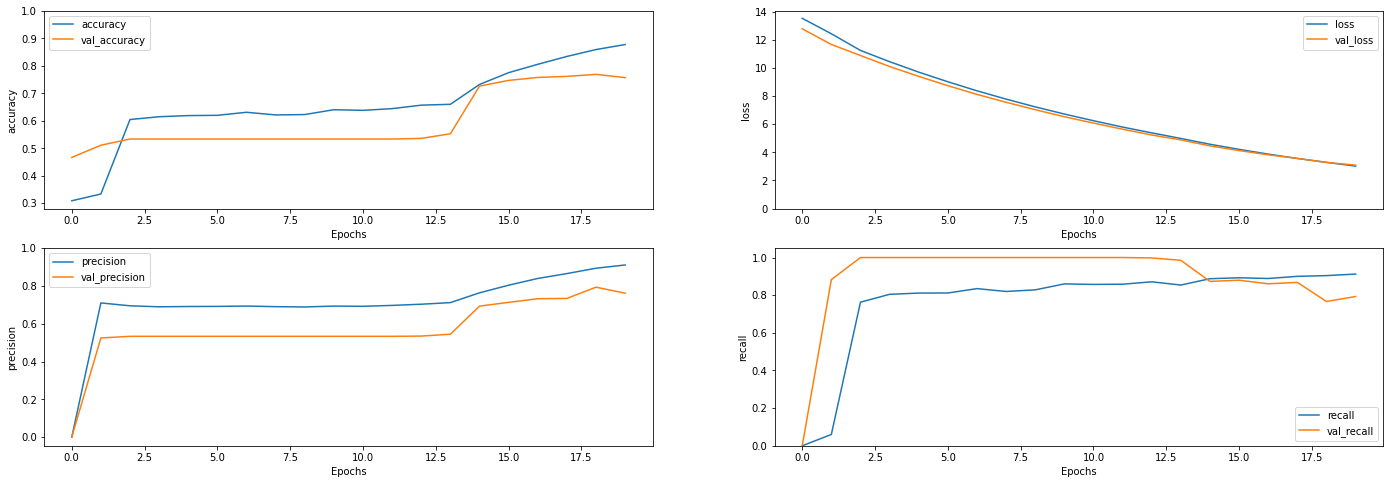

In [33]:
plt.figure(figsize=(24, 8))
plt.subplot(2, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(2, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

plt.subplot(2, 2, 3)
plot_graphs(history, 'precision')
plt.ylim(None, 1)
plt.subplot(2, 2, 4)
plot_graphs(history, 'recall')
plt.ylim(0, None)

In [34]:
tf.keras.models.save_model(model, 'q1_model')

INFO:tensorflow:Assets written to: q1_model\assets


INFO:tensorflow:Assets written to: q1_model\assets


In [29]:
reconstructed_model = tf.keras.models.load_model("q1_model")

In [30]:
predictions = reconstructed_model.predict(validation_data['preprocessed_tweet_text'])
predictions[:5]

array([[0.3834071 ],
       [0.90896904],
       [0.9252968 ],
       [0.9286399 ],
       [0.8261465 ]], dtype=float32)

In [31]:
validation_data['predicted_q1'] = predictions
validation_data['predicted_q1'] = validation_data.apply(lambda row: 0 if row['predicted_q1'] < 0.5 else 1, axis=1)

In [32]:
from sklearn.metrics import confusion_matrix

cm_q2 = confusion_matrix(validation_data['q1_label'], validation_data['predicted_q1'])
pd.DataFrame(cm_q2, index=['Actual no', 'Actual yes'], columns = ['Predicted no', 'Predicted yes'])

,Predicted no,Predicted yes
Actual no,676,152
Actual yes,342,605


## LSTM for Q2-Q4 in case Q1 is 'yes'
- **Q2: False Information: To what extent does the tweet appear to contain false information?**
The stated claim may contain false information. This question labels the tweets with the categories mentioned below. False Information appears on social media platforms, blogs, and news-articles to deliberately misinform or deceive the readers.


- **Q3: Interest to General Public: Will the tweet have an effect on or be of interest to the general public?**
Most often people do not make interesting claims, which can be verified by our general knowledge. For example, "Sky is blue'' is a claim, however, it is not interesting to the general public. In general, topics such as healthcare, political news and findings, and current events are of higher interest to the general public. Using the five point Likert scale the labels are defined below.


- **Q4: Harmfulness: To what extent is the tweet harmful to the society/person(s)/company(s)/product(s)?**
The purpose of this question is to determine if the content of the tweet aims to and can negatively affect the society as a whole, specific person(s), company(s), product(s) or spread rumors about them. The content intends to harm or weaponize the information. A rumor involves a form of a statement whose veracity is not quickly or ever confirmed.


- Q2_p: should be either yes/no depending on the answer to the second question as described in Data Annotation or nan if Q1_p is no. 
- Q3_p: should be either yes/no depending on the answer to the third question as described in Data Annotation or nan if Q1_p is no. 
- Q4_p: should be either yes/no depending on the answer to the fourth question as described in Data Annotation or nan if Q1_p is no.

In [28]:
train_data = train_data[train_data['q1_label'] == 1]
validation_data = validation_data[validation_data['q1_label'] == 1]

In [29]:
train_data.head(3)

,preprocessed_tweet_text,q1_label,q2_label_is_no,q2_label_is_unknown,q2_label_is_yes,q3_label_is_no,q3_label_is_unknown,q3_label_is_yes,q4_label_is_no,q4_label_is_unknown,q4_label_is_yes
4,"This is the face of someone who just spent 9 hours in personal protective equipment moving critically ill Covid19 patients around London. I feel broken - and we are only at the start. I am begging people, please please do social distancing and self isolation #covid19 URL",1,1,0,0,0,0,1,1,0,0
5,"Yesterday I knocked on my Tennant's door and told him he can stay in the property rent free for 5 months. He is self employed with 4 kids. I don't need Boris to tell me what is morally correct. Landlords, if you can, do more, do something. #COVID19 #BeNice",1,1,0,0,1,0,0,1,0,0
7,This is Dr. Usama Riaz. He spent past weeks screening and treating patients with Corona Virus in Pakistan. He knew there was no PPE. He persisted anyways. Today he lost his own battle with coronavirus but he gave life and hope to so many more. KNOW HIS NAME :loudly_crying_face: :red_heart: URL,1,1,0,0,0,0,1,1,0,0


In [30]:
encoded_X_train = encoder(train_data['preprocessed_tweet_text']).numpy()
encoded_X_validation = encoder(validation_data['preprocessed_tweet_text']).numpy()

def format_output(dataframe):
    output_q2 = dataframe[['q2_label_is_no', 'q2_label_is_unknown', 'q2_label_is_yes']]
    output_q3 = dataframe[['q3_label_is_no', 'q3_label_is_unknown', 'q3_label_is_yes']]
    output_q4 = dataframe[['q4_label_is_no', 'q4_label_is_unknown', 'q4_label_is_yes']]
    return output_q2, output_q3, output_q4

y_train = format_output(train_data)
y_validation = format_output(validation_data)

In [31]:
def build_model():
    # Define model layers. input_layer receives the encoded text
    input_layer = tf.keras.layers.Input(shape=(MAX_ENCODED_LEN,))
    embedding_layer = tf.keras.layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=64)(input_layer)
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(embedding_layer)
    dense1 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1))(lstm)
    dropout1 = tf.keras.layers.Dropout(0.2)(dense1)
    
    dense2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1))(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.05)(dense2)
    
    dense3 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1))(dropout1)
    dropout3 = tf.keras.layers.Dropout(0.05)(dense3)
    
    dense4 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1))(dropout1)
    dropout4 = tf.keras.layers.Dropout(0.05)(dense4)
    
    # Y2 output will be the answer to Q2_label
    y2_output = tf.keras.layers.Dense(3, activation='softmax', name='q2_label')(dropout2)
    
    # Y3 output will be the answer to Q3_label
    y3_output = tf.keras.layers.Dense(3, activation='softmax', name='q3_label')(dropout3)
    
    # Y4 output will be the answer to Q4_label
    y4_output = tf.keras.layers.Dense(3, activation='softmax', name='q4_label')(dropout4)
    
    # Define the model with the input layer 
    # and the list of output layers
    model = tf.keras.Model(inputs=input_layer,outputs=[y2_output, y3_output, y4_output])
    return model

In [32]:
model = build_model()

In [33]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer=tf.keras.optimizers.Adam(1e-4)
model.compile(optimizer=optimizer,
              loss={'q2_label': tf.keras.losses.CategoricalCrossentropy(), 
                    'q3_label': tf.keras.losses.CategoricalCrossentropy(),
                    'q4_label': tf.keras.losses.CategoricalCrossentropy()
                   },
             metrics={'q2_label':tf.keras.metrics.CategoricalAccuracy(),
                      'q3_label':tf.keras.metrics.CategoricalAccuracy(),
                      'q4_label':tf.keras.metrics.CategoricalAccuracy()
             })

In [34]:
history = model.fit(encoded_X_train, y_train,
   epochs=20, batch_size=256, validation_data=(encoded_X_validation, y_validation))

Epoch 1/20
18/18 [==============================] - 10s 360ms/step - loss: 24.4336 - q2_label_loss: 1.0843 - q3_label_loss: 1.0953 - q4_label_loss: 1.0963 - q2_label_categorical_accuracy: 0.8564 - q3_label_categorical_accuracy: 0.4257 - q4_label_categorical_accuracy: 0.3941 - val_loss: 24.1106 - val_q2_label_loss: 1.0741 - val_q3_label_loss: 1.0800 - val_q4_label_loss: 1.0891 - val_q2_label_categorical_accuracy: 0.9050 - val_q3_label_categorical_accuracy: 0.9926 - val_q4_label_categorical_accuracy: 0.8638
Epoch 2/20
18/18 [==============================] - 7s 369ms/step - loss: 23.8566 - q2_label_loss: 1.0674 - q3_label_loss: 1.0693 - q4_label_loss: 1.0895 - q2_label_categorical_accuracy: 0.8740 - q3_label_categorical_accuracy: 0.9458 - q4_label_categorical_accuracy: 0.7534 - val_loss: 23.5327 - val_q2_label_loss: 1.0548 - val_q3_label_loss: 1.0496 - val_q4_label_loss: 1.0815 - val_q2_label_categorical_accuracy: 0.9050 - val_q3_label_categorical_accuracy: 0.9926 - val_q4_label_categori

In [35]:
q2_predictions, q3_predictions, q4_predictions = model.predict(encoded_X_validation)

In [36]:
q2_predictions

array([[0.85056406, 0.03110933, 0.11832664],
       [0.85039014, 0.03113224, 0.11847756],
       [0.85056776, 0.03103727, 0.11839498],
       ...,
       [0.8503706 , 0.03107505, 0.11855432],
       [0.8498998 , 0.03123876, 0.11886139],
       [0.8506151 , 0.0310285 , 0.11835643]], dtype=float32)

In [37]:
q3_predictions

array([[0.02777432, 0.01450785, 0.9577178 ],
       [0.02782738, 0.01451997, 0.9576526 ],
       [0.02761234, 0.01442806, 0.9579596 ],
       ...,
       [0.0276253 , 0.01441199, 0.9579627 ],
       [0.02771797, 0.01454764, 0.9577344 ],
       [0.02763391, 0.01440237, 0.95796376]], dtype=float32)

In [38]:
q4_predictions

array([[0.83537775, 0.03051426, 0.1341079 ],
       [0.8352385 , 0.03054755, 0.13421397],
       [0.83592933, 0.03033586, 0.13373479],
       ...,
       [0.83606917, 0.03031762, 0.13361323],
       [0.83520186, 0.03058035, 0.1342178 ],
       [0.8356801 , 0.03045404, 0.1338658 ]], dtype=float32)

In [39]:
validation_data

,preprocessed_tweet_text,q1_label,q2_label_is_no,q2_label_is_unknown,q2_label_is_yes,q3_label_is_no,q3_label_is_unknown,q3_label_is_yes,q4_label_is_no,q4_label_is_unknown,q4_label_is_yes
0,"Unlike mRNA vaccines, which must be stored at -20 degrees C, adenovirus vaccines can be refrigerated for up to three months at 36–46 degrees F. That means it can be distributed more easily in doctor’s offices, pharmacies, clinics, or anywhere else. https://t.co/uLjAqopvbx publichealth what need know about johnson johnson vaccine",1,1,0,0,0,0,1,1,0,0
1,"We've published new guidance on the information we would need to approve any modifications to authorised COVID-19 vaccines, should virus mutations make them less effective at preventing the disease. Find out more: https://t.co/GV7DwTKAje https://t.co/FTw9gDmt0s t twitter Agovuk status photo",1,1,0,0,0,0,1,1,0,0
2,"1,769,695 Londoners have received their first dose of a COVID-19 vaccine, and the total number of first and second doses given up to and including 22 February is now 1,837,280. There's a lot of misinformation about the vaccines going round—ignore it. They will save lives.",1,1,0,0,0,0,1,1,0,0
3,A Texas doctor gave out 10 doses of the Moderna COVID-19 vaccine after an opened vial was set to expire in 6 hours. Then he was charged with stealing the vaccine and was fired from his job. https://t.co/h6Aln28Q66 https://t.co/ZquXEu5jk2 webmd twitter vaccines covid vaccine news texas doctor fired giving expiring vaccines status photo,1,1,0,0,0,0,1,0,0,1
4,"The media and Republicans are trying to give Trump credit for the coronavirus vaccine, but the truth is the vaccines were in development months before Operation Warp Speed. https://t.co/6qOnyCGf2H via @politicususa politicususa trump credit covid vaccine html",1,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1752,Iraq imports one million doses of the Sputnik vaccine in Russia https://t.co/MsG6YMg2LaIraq imports one million doses of the Sputin vaccine/ t Iraq,1,1,0,0,0,0,1,1,0,0
1757,The Ministry of Health approves the first hospital specialized in providing Corona vaccination in the Kingdom,1,1,0,0,0,0,1,1,0,0
1765,H #Partial_ban https://t.co/CF3OtpBTNU twitter karim alsharari status video,1,1,0,0,0,0,1,1,0,0
1769,"Saudi Arabia donates corona vaccines to Sudan, Ghana, Cote d&#39;Ivoire, Nigeria and others https://t.co/CgwJzgOm4v twitter ambkattan status",1,1,0,0,0,0,1,1,0,0


In [40]:
validation_data['q2_label'] = validation_data.apply(lambda row: np.argmax(row[['q2_label_is_no', 'q2_label_is_unknown', 'q2_label_is_yes']]), axis=1)
validation_data['q3_label'] = validation_data.apply(lambda row: np.argmax(row[['q3_label_is_no', 'q3_label_is_unknown', 'q3_label_is_yes']]), axis=1)
validation_data['q4_label'] = validation_data.apply(lambda row: np.argmax(row[['q4_label_is_no', 'q4_label_is_unknown', 'q4_label_is_yes']]), axis=1)

validation_data['predicted_q2'] = np.argmax(q2_predictions, axis=1)
validation_data['predicted_q3'] = np.argmax(q3_predictions, axis=1)
validation_data['predicted_q4'] = np.argmax(q4_predictions, axis=1)

In [41]:
from sklearn.metrics import confusion_matrix

cm_q2 = confusion_matrix(validation_data['q2_label'], validation_data['predicted_q2'])
pd.DataFrame(cm_q2, index=['Actual no', 'Actual unknown', 'Actual yes'], columns = ['Predicted no', 'Predicted unknown', 'Predicted yes'])

,Predicted no,Predicted unknown,Predicted yes
Actual no,857,0,0
Actual unknown,19,0,0
Actual yes,71,0,0


In [42]:
validation_data['q3_label'].unique()

array([2, 0], dtype=int64)

In [43]:
cm_q3 = confusion_matrix(validation_data['q3_label'], validation_data['predicted_q3'])
pd.DataFrame(cm_q3, index=['Actual no', 'Actual yes'], columns = ['Predicted no', 'Predicted yes'])

,Predicted no,Predicted yes
Actual no,0,7
Actual yes,0,940


In [44]:
cm_q4 = confusion_matrix(validation_data['q4_label'], validation_data['predicted_q4'])
pd.DataFrame(cm_q4, index=['Actual no', 'Actual unknown', 'Actual yes'], columns = ['Predicted no', 'Predicted unknown', 'Predicted yes'])

,Predicted no,Predicted unknown,Predicted yes
Actual no,818,0,0
Actual unknown,3,0,0
Actual yes,126,0,0


In [45]:
train_data['q2_label'] = train_data.apply(lambda row: np.argmax(row[['q2_label_is_no', 'q2_label_is_unknown', 'q2_label_is_yes']]), axis=1).map({0: 'no', 1:'unknown', 2:'yes'})
train_data['q3_label'] = train_data.apply(lambda row: np.argmax(row[['q3_label_is_no', 'q3_label_is_unknown', 'q3_label_is_yes']]), axis=1).map({0: 'no', 1:'unknown', 2:'yes'})
train_data['q4_label'] = train_data.apply(lambda row: np.argmax(row[['q4_label_is_no', 'q4_label_is_unknown', 'q4_label_is_yes']]), axis=1).map({0: 'no', 1:'unknown', 2:'yes'})

In [46]:
train_data[['q2_label']].value_counts()

q2_label
no          3871
yes          479
unknown       78
dtype: int64

In [47]:
train_data[['q3_label']].value_counts()

q3_label
yes         4282
no           128
unknown       18
dtype: int64

In [48]:
train_data[['q4_label']].value_counts()

q4_label
no          3719
yes          682
unknown       27
dtype: int64

### Trying to fix overfitting issue with the trained augmented_data

In [25]:
augmented_train_data = pd.read_csv('../dataset/train_augmented.tsv', sep='\t')
augmented_train_data = augmented_train_data[augmented_train_data['q1_label'] == 'yes']
augmented_train_data = augmented_train_data.fillna('unknown')

augmented_train_data = augmented_train_data[['preprocessed_tweet_text', 'q2_label', 'q3_label', 'q4_label']]

augmented_train_data.head(2)

,preprocessed_tweet_text,q2_label,q3_label,q4_label
8,"This is the Race of someone who just spsnt 9 hourW in personal protective equipment moCing critically ill Covid19 patients around London. I feel brokFn - and we are on<y at the start. I am begHinT people, please please do social distancing and selB isolSRion # Dovid1i URL",no,yes,no
9,"Htis is the face of smoeoen who juts spent 9 hours in persnola protective equipment moving critically ill Covid19 patients around London. I feel broken - and we are olny at the statr. I am begging people, please plesae do social idstancgin and self islaotion # covi9d1 URL",no,yes,no


In [26]:
train_data = train_data[train_data['q1_label'] == 1]
validation_data = validation_data[validation_data['q1_label'] == 1]

This time I am going to train the models for the Q2, Q3 and Q4 questions separately.

#### Add augmented data to the least occuring classes in Q2 ('yes' and 'unknown')

In [27]:
part_of_augmented = augmented_train_data[augmented_train_data['q2_label'].isin(['yes', 'unknown'])]
one_hot_encode_aug_q2 = pd.get_dummies(part_of_augmented, columns=['q2_label', 'q3_label', 'q4_label'], prefix=["q2_label_is", "q3_label_is", "q4_label_is"])

In [28]:
train_data_for_q2 = train_data.append(one_hot_encode_aug_q2)
train_data_for_q2['q2_label_is_no'] = train_data_for_q2['q2_label_is_no'].fillna(0)
train_data_for_q2['q2_label'] = train_data_for_q2.apply(lambda row: 'no' if row['q2_label_is_no'] == 1 else ('unknown' if row['q2_label_is_unknown'] else 'yes') , axis=1)
train_data_for_q2['q2_label'].value_counts()

yes        4311
no         3871
unknown     702
Name: q2_label, dtype: int64

In [29]:
train_data_for_q2 = train_data_for_q2.sample(frac=1)

In [30]:
train_dataset_for_q2 = tf.data.Dataset.from_tensor_slices(((train_data_for_q2['preprocessed_tweet_text'], train_data_for_q2['q2_label'])))

In [31]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_ENCODED_LEN)
encoder.adapt(train_dataset_for_q2.map(lambda text, label: text))

In [32]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(1e-3),
      metrics=['accuracy'])

In [33]:
history = model.fit(train_data_for_q2['preprocessed_tweet_text'], train_data_for_q2[['q2_label_is_no','q2_label_is_unknown','q2_label_is_yes']], batch_size=64, epochs=5, 
                    validation_data=(validation_data['preprocessed_tweet_text'], validation_data[['q2_label_is_no','q2_label_is_unknown','q2_label_is_yes']]))

Epoch 1/5
139/139 [==============================] - 14s 80ms/step - loss: 6.0301 - accuracy: 0.5073 - val_loss: 2.0725 - val_accuracy: 0.5797
Epoch 2/5
139/139 [==============================] - 11s 77ms/step - loss: 1.0464 - accuracy: 0.8268 - val_loss: 0.6758 - val_accuracy: 0.8543
Epoch 3/5
139/139 [==============================] - 11s 79ms/step - loss: 0.3844 - accuracy: 0.9557 - val_loss: 0.5633 - val_accuracy: 0.8775
Epoch 4/5
139/139 [==============================] - 11s 80ms/step - loss: 0.2683 - accuracy: 0.9757 - val_loss: 0.5591 - val_accuracy: 0.8796
Epoch 5/5
139/139 [==============================] - 11s 79ms/step - loss: 0.2193 - accuracy: 0.9845 - val_loss: 0.5693 - val_accuracy: 0.8807


In [34]:
predictions_q2 = model.predict(validation_data['preprocessed_tweet_text'])
predictions_q2[:5]

array([[0.93472165, 0.03340579, 0.03187265],
       [0.9817832 , 0.00738535, 0.01083145],
       [0.98095727, 0.006977  , 0.01206575],
       [0.98224187, 0.0070759 , 0.01068221],
       [0.98250616, 0.00659674, 0.01089713]], dtype=float32)

In [35]:
predictions_q2 = np.argmax(predictions_q2, axis=1)

In [36]:
validation_data['q2_label'] = validation_data.apply(lambda row: 0 if row['q2_label_is_no'] == 1 else (1 if row['q2_label_is_unknown'] == 1 else 2) , axis=1)

In [37]:
cm_q2 = confusion_matrix(validation_data['q2_label'], predictions_q2)
pd.DataFrame(cm_q2, index=['Actual no', 'Actual unknown', 'Actual yes'], columns = ['Predicted no', 'Predicted unknown', 'Predicted yes'])

,Predicted no,Predicted unknown,Predicted yes
Actual no,827,4,26
Actual unknown,19,0,0
Actual yes,63,1,7


In [38]:
pd.DataFrame(classification_report(validation_data['q2_label'], predictions_q2, zero_division=0, output_dict=True)).rename(columns={'0': 'No', '1': 'Unknown', '2': 'Yes'})

,No,Unknown,Yes,accuracy,macro avg,weighted avg
precision,0.909791,0.0,0.212121,0.880676,0.373971,0.839231
recall,0.964994,0.0,0.098592,0.880676,0.354529,0.880676
f1-score,0.936580,0.0,0.134615,0.880676,0.357065,0.857663
support,857.000000,19.0,71.000000,0.880676,947.000000,947.000000


No big improvement, but still better.

#### Add augmented data to the least occuring classes in Q3 ('no' and 'unknown')

In [39]:
one_hot_encode_aug_q3 = pd.get_dummies(augmented_train_data[augmented_train_data['q3_label'].isin(['no', 'unknown'])], columns=['q2_label', 'q3_label', 'q4_label'], prefix=["q2_label_is", "q3_label_is", "q4_label_is"])

In [40]:
train_data_for_q3 = train_data.append(one_hot_encode_aug_q3)
train_data_for_q3['q3_label_is_yes'] = train_data_for_q3['q3_label_is_yes'].fillna(0)
train_data_for_q3['q3_label'] = train_data_for_q3.apply(lambda row: 'no' if row['q3_label_is_no'] == 1 else ('unknown' if row['q3_label_is_unknown'] else 'yes') , axis=1)
train_data_for_q3['q3_label'].value_counts()

yes        4282
no         1152
unknown     162
Name: q3_label, dtype: int64

In [41]:
train_data_for_q3 = train_data_for_q3.sample(frac=1)

In [42]:
train_dataset_for_q3 = tf.data.Dataset.from_tensor_slices(((train_data_for_q3['preprocessed_tweet_text'], train_data_for_q3['q3_label'])))

In [43]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_ENCODED_LEN)
encoder.adapt(train_dataset_for_q3.map(lambda text, label: text))

In [44]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(1e-3),
      metrics=['accuracy'])

In [45]:
history = model.fit(train_data_for_q3['preprocessed_tweet_text'], train_data_for_q3[['q3_label_is_no','q3_label_is_unknown','q3_label_is_yes']], batch_size=64, epochs=5, 
                    validation_data=(validation_data['preprocessed_tweet_text'], validation_data[['q3_label_is_no','q3_label_is_unknown','q3_label_is_yes']]))

Epoch 1/5
88/88 [==============================] - 11s 92ms/step - loss: 7.5488 - accuracy: 0.7564 - val_loss: 3.1547 - val_accuracy: 0.9926
Epoch 2/5
88/88 [==============================] - 7s 83ms/step - loss: 1.8914 - accuracy: 0.8758 - val_loss: 0.7600 - val_accuracy: 0.9778
Epoch 3/5
88/88 [==============================] - 7s 85ms/step - loss: 0.5572 - accuracy: 0.9603 - val_loss: 0.2726 - val_accuracy: 0.9768
Epoch 4/5
88/88 [==============================] - 7s 84ms/step - loss: 0.2768 - accuracy: 0.9675 - val_loss: 0.1730 - val_accuracy: 0.9810
Epoch 5/5
88/88 [==============================] - 7s 85ms/step - loss: 0.2171 - accuracy: 0.9664 - val_loss: 0.1307 - val_accuracy: 0.9894


In [46]:
predictions_q3 = model.predict(validation_data['preprocessed_tweet_text'])
predictions_q3[:5]

array([[0.0038464 , 0.00246696, 0.9936866 ],
       [0.00442348, 0.00284217, 0.9927343 ],
       [0.00374871, 0.00240339, 0.9938479 ],
       [0.00368682, 0.00236321, 0.99395   ],
       [0.00499758, 0.0032156 , 0.9917868 ]], dtype=float32)

In [47]:
predictions_q3 = np.argmax(predictions_q3, axis=1)

In [48]:
validation_data['q3_label'] = validation_data.apply(lambda row: 0 if row['q3_label_is_no'] == 1 else (1 if row['q3_label_is_unknown'] == 1 else 2) , axis=1)

In [49]:
np.unique(predictions_q3)

array([0, 2], dtype=int64)

In [50]:
cm_q3 = confusion_matrix(validation_data['q3_label'], predictions_q3)
pd.DataFrame(cm_q3, index=['Actual no', 'Actual yes'], columns = ['Predicted no', 'Predicted yes'])

,Predicted no,Predicted yes
Actual no,2,5
Actual yes,5,935


In [51]:
pd.DataFrame(classification_report(validation_data['q3_label'], predictions_q3, zero_division=0, output_dict=True)).rename(columns={'0': 'No', '1': 'Unknown', '2': 'Yes'})

,No,Yes,accuracy,macro avg,weighted avg
precision,0.285714,0.994681,0.98944,0.640198,0.98944
recall,0.285714,0.994681,0.98944,0.640198,0.98944
f1-score,0.285714,0.994681,0.98944,0.640198,0.98944
support,7.000000,940.000000,0.98944,947.000000,947.00000


No big improvement, but still better.

#### Add augmented data to the least occuring classes in Q4 ('yes' and 'unknown')

In [52]:
one_hot_encode_aug_q4 = pd.get_dummies(augmented_train_data[augmented_train_data['q4_label'].isin(['yes', 'unknown'])], columns=['q2_label', 'q3_label', 'q4_label'], prefix=["q2_label_is", "q3_label_is", "q4_label_is"])

In [53]:
train_data_for_q4 = train_data.append(one_hot_encode_aug_q4)
train_data_for_q4['q4_label_is_no'] = train_data_for_q4['q4_label_is_no'].fillna(0)
train_data_for_q4['q4_label'] = train_data_for_q4.apply(lambda row: 'no' if row['q4_label_is_no'] == 1 else ('unknown' if row['q4_label_is_unknown'] else 'yes') , axis=1)
train_data_for_q4['q4_label'].value_counts()

yes        6138
no         3719
unknown     243
Name: q4_label, dtype: int64

In [54]:
train_data_for_q4 = train_data_for_q4.sample(frac=1)

In [55]:
train_dataset_for_q4 = tf.data.Dataset.from_tensor_slices(((train_data_for_q4['preprocessed_tweet_text'], train_data_for_q4['q4_label'])))

In [56]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_ENCODED_LEN)
encoder.adapt(train_dataset_for_q4.map(lambda text, label: text))

In [57]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(1e-3),
      metrics=['accuracy'])

In [58]:
history = model.fit(train_data_for_q4['preprocessed_tweet_text'], train_data_for_q4[['q4_label_is_no','q4_label_is_unknown','q4_label_is_yes']], batch_size=64, epochs=5, 
                    validation_data=(validation_data['preprocessed_tweet_text'], validation_data[['q4_label_is_no','q4_label_is_unknown','q4_label_is_yes']]))

Epoch 1/5
158/158 [==============================] - 18s 91ms/step - loss: 5.4045 - accuracy: 0.5901 - val_loss: 1.7070 - val_accuracy: 0.2027
Epoch 2/5
158/158 [==============================] - 13s 85ms/step - loss: 0.9463 - accuracy: 0.7549 - val_loss: 1.0119 - val_accuracy: 0.1331
Epoch 3/5
158/158 [==============================] - 13s 85ms/step - loss: 0.5726 - accuracy: 0.8145 - val_loss: 0.6683 - val_accuracy: 0.7888
Epoch 4/5
158/158 [==============================] - 13s 85ms/step - loss: 0.3125 - accuracy: 0.9449 - val_loss: 0.5534 - val_accuracy: 0.8363
Epoch 5/5
158/158 [==============================] - 14s 86ms/step - loss: 0.2434 - accuracy: 0.9614 - val_loss: 0.5493 - val_accuracy: 0.8490


In [59]:
predictions_q4 = model.predict(validation_data['preprocessed_tweet_text'])
predictions_q4[:5]

array([[0.05528215, 0.02947147, 0.91524637],
       [0.9330186 , 0.03139218, 0.03558916],
       [0.9375733 , 0.02963018, 0.03279643],
       [0.93726146, 0.02975632, 0.03298225],
       [0.6242473 , 0.0689215 , 0.30683118]], dtype=float32)

In [60]:
predictions_q4 = np.argmax(predictions_q4, axis=1)

In [61]:
validation_data['q4_label'] = validation_data.apply(lambda row: 0 if row['q4_label_is_no'] == 1 else (1 if row['q4_label_is_unknown'] == 1 else 2) , axis=1)

In [62]:
cm_q4 = confusion_matrix(validation_data['q4_label'], predictions_q4)
pd.DataFrame(cm_q4, index=['Actual no', 'Actual unknown', 'Actual yes'], columns = ['Predicted no', 'Predicted unknown', 'Predicted yes'])

,Predicted no,Predicted unknown,Predicted yes
Actual no,781,0,37
Actual unknown,3,0,0
Actual yes,103,0,23


In [63]:
pd.DataFrame(classification_report(validation_data['q4_label'], predictions_q4, zero_division=0, output_dict=True)).rename(columns={'0': 'No', '1': 'Unknown', '2': 'Yes'})

,No,Unknown,Yes,accuracy,macro avg,weighted avg
precision,0.880496,0.0,0.383333,0.848997,0.421276,0.811558
recall,0.954768,0.0,0.182540,0.848997,0.379102,0.848997
f1-score,0.916129,0.0,0.247312,0.848997,0.387814,0.824240
support,818.000000,3.0,126.000000,0.848997,947.000000,947.000000


No big improvement, but still better.